Datasets used: 
- `Law School Success` :<br>
The dataset was originally collected for a study called 'LSAC National Longitudinal Bar Passage Study'. It includes background information and if (and how) candidates passed the bar exam to become lawyers/legal practicioners in the USA<br>

    Important Variables:
    
    gender: Gender of the student.<br>
    lsat: LSAT score received by the student.<br>
    pass_bar: Ground truth label indicating whether or not the student eventually passed the bar.<br>
    race: Race of the student.<br>
    gpa: A student's undergraduate GPA.<br>

Reference Links: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage?resource=download

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse
from aif360.sklearn.datasets import fetch_adult
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


## Load Dataset

In [2]:
DATAFILE= "bar_pass_prediction.csv"

learning_class_weights = {0: 50, 1: 5}

X = pd.read_csv(DATAFILE)
#Drop unnecessary features
X = X.drop(columns=['sex','dnn_bar_pass_prediction','ID','bar_passed','race',
                    'race2','decile1b','decile3','decile1','zfygpa','asian','black','hisp','other','index6040','bar1','bar2','DOB_yr','male','bar','indxgrp','indxgrp2','grad'
                    ,'bar1_yr','bar2_yr','parttime','age','cluster'])
num_features = X._get_numeric_data().columns.to_list()

df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()
df = df.dropna()
df = df.reset_index(drop=True)

df.head()

,lsat,ugpa,zgpa,fulltime,fam_inc,gender,race1,Dropout,pass_bar,tier,gpa
0,44.0,3.5,1.88,1.0,5.0,female,white,NO,1,4.0,3.5
1,29.0,3.5,-0.57,1.0,4.0,female,white,NO,1,2.0,3.5
2,36.0,3.5,-1.12,1.0,1.0,male,white,NO,1,3.0,3.5
3,39.0,3.5,-0.49,1.0,4.0,male,white,NO,1,3.0,3.5
4,48.0,3.5,0.76,1.0,4.0,male,white,NO,1,5.0,3.5


## Model training and test

In [3]:
X = df.drop('pass_bar', axis=1)
y = df['pass_bar']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500,class_weight = learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='labels')
model.predict(X_test.iloc[:100, :])

CPU times: total: 62.5 ms
Wall time: 230 ms


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.])

In [5]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.23      0.71      0.34       315
           1       0.98      0.87      0.92      5900

    accuracy                           0.86      6215
   macro avg       0.60      0.79      0.63      6215
weighted avg       0.94      0.86      0.89      6215



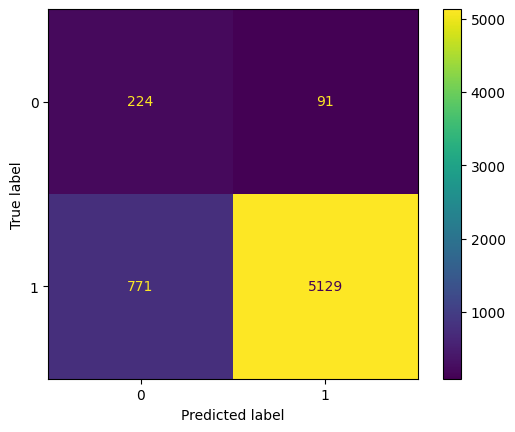

In [6]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [7]:
for col in cate_features:
    X_test[col] = X_test[col].astype('object')

In [8]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
     X_test,
     model=model,
     sensitive_attribute='gender',
     missing_subgroup_val="Unknown"
 )

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████| 2411/2411 [00:14<00:00, 166.29it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 16674/16674 [02:41<00:00, 103.29it/s]


Number of if-thens: 16674


In [9]:
 #### Uncomment if you wish to save rules object on disk

import dill

with open("rulesLawSchool.data", "wb") as outf:
     dill.dump(rules_by_if, outf)

In [8]:

# import dill

# with open("rulesLawSchool.data", "rb") as inf:
#     rules_by_if = dill.load(inf)


In [10]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["male"][1][0][1]-e[1]["female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If race1 = white, lsat = 34.0, fam_inc = 3.0:
	Subgroup 'female', 1.0438% covered
		Make lsat = 39.0, fam_inc = 4.0 with correctness 0.0000%.
		Make lsat = 40.0, fam_inc = 4.0 with correctness 0.0000%.
		Make lsat = 38.0, fam_inc = 4.0 with correctness 0.0000%.
		Make lsat = 37.0, fam_inc = 4.0 with correctness 0.0000%.
		Make lsat = 41.0, fam_inc = 4.0 with correctness 20.0000%.
		Make lsat = 42.0, fam_inc = 4.0 with correctness 20.0000%.
		Make lsat = 37.0 with correctness 0.0000%.
		Make lsat = 42.0 with correctness 0.0000%.
		Make fam_inc = 4.0 with correctness 0.0000%.
		Make lsat = 44.0, fam_inc = 4.0 with correctness 20.0000%.
		Make lsat = 33.0, fam_inc = 4.0 with correctness 0.0000%.
		Make lsat = 33.0 with correctness 0.0000%.
		Make lsat = 38.0 with correctness 0.0000%.
		Make lsat = 45.0, fam_inc = 4.0 with correctness 20.0000%.
		Make lsat = 44.0 with correctness 20.0000%.
	Subgroup 'male', 1.2048% covered
		Make lsat = 39.0, fam_inc = 4.0 with correctness 83.3333%.
		Make

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [14]:
feature_weights = {"gender": 1, "race1": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [15]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs
))

If ugpa = 2.8, fam_inc = 3.0, gpa = 2.8, fulltime = 2.0:
	Subgroup 'female', 1.0438% covered out of 9064
		Make ugpa = 3.2, gpa = 3.2, fulltime = 1.0 with correctness 20.0000%.
		Make ugpa = 3.7, gpa = 3.7, fulltime = 1.0 with correctness 20.0000%.
		Make ugpa = 3.9, gpa = 3.9, fulltime = 1.0 with correctness 20.0000%.
		Make fulltime = 1.0 with correctness 20.0000%.
		Aggregate cost of the above recourses = 0.5
	Subgroup 'male', 1.2048% covered out of 11652
		Make ugpa = 3.2, gpa = 3.2, fulltime = 1.0 with correctness 83.3333%.
		Make ugpa = 3.7, gpa = 3.7, fulltime = 1.0 with correctness 83.3333%.
		Make ugpa = 3.9, gpa = 3.9, fulltime = 1.0 with correctness 83.3333%.
		Make fulltime = 1.0 with correctness 83.3333%.
		Aggregate cost of the above recourses = 2.08333
If ugpa = 2.8, gpa = 2.8, fulltime = 2.0:
	Subgroup 'female', 1.4614% covered out of 9064
		Make ugpa = 3.1, gpa = 3.1, fulltime = 1.0 with correctness 28.5714%.
		Make ugpa = 3.7, gpa = 3.7, fulltime = 1.0 with correctnes

## Minimum cost above threshold

In [16]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs
))

If tier = 1.0:
	Subgroup 'female', 6.2630% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.0241% covered out of 11652
		Make tier = 6.0 with correctness 56.6667%.
		Aggregate cost of the above recourses = 1.0
If Dropout = NO, tier = 1.0:
	Subgroup 'female', 6.2630% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.0241% covered out of 11652
		Make tier = 6.0 with correctness 56.6667%.
		Aggregate cost of the above recourses = 1.0
If Dropout = NO, tier = 1.0, fulltime = 1.0:
	Subgroup 'female', 6.0543% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.0241% covered out of 11652
		Make tier = 6.0 with correctness 56.6667%.
		Aggregate cost of the above recourses = 1.0
If tier = 1.0, fulltime = 1.0:
	Subgroup 'female', 6.0543% covered out of 9064
		No recourses for this subgroup!


## Cost above threshold

In [19]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="total-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs
))

If tier = 1.0:
	Subgroup 'female', 6.2630% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.0241% covered out of 11652
		Make tier = 6.0 with correctness 56.6667%.
		Aggregate cost of the above recourses = 1.0
If Dropout = NO, tier = 1.0:
	Subgroup 'female', 6.2630% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.0241% covered out of 11652
		Make tier = 6.0 with correctness 56.6667%.
		Aggregate cost of the above recourses = 1.0
If Dropout = NO, tier = 1.0, fulltime = 1.0:
	Subgroup 'female', 6.0543% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.0241% covered out of 11652
		Make tier = 6.0 with correctness 56.6667%.
		Aggregate cost of the above recourses = 1.0
If tier = 1.0, fulltime = 1.0:
	Subgroup 'female', 6.0543% covered out of 9064
		No recourses for this subgroup!


## Number above threshold

In [21]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs
))

If ugpa = 3.0, tier = 2.0, fulltime = 1.0:
	Subgroup 'female', 1.0438% covered out of 9064
		Make ugpa = 3.7, tier = 6.0 with correctness 60.0000%.
		Make ugpa = 3.6, tier = 6.0 with correctness 60.0000%.
		Make ugpa = 3.5, tier = 6.0 with correctness 60.0000%.
		Make ugpa = 3.8, tier = 6.0 with correctness 60.0000%.
		Aggregate cost of the above recourses = 4.0
	Subgroup 'male', 1.6064% covered out of 11652
		Make ugpa = 3.2, tier = 3.0 with correctness 62.5000%.
		Make ugpa = 3.1, tier = 3.0 with correctness 62.5000%.
		Make tier = 3.0 with correctness 62.5000%.
		Make ugpa = 3.5, tier = 4.0 with correctness 62.5000%.
		Make ugpa = 3.5, tier = 3.0 with correctness 62.5000%.
		Make ugpa = 3.7, tier = 4.0 with correctness 62.5000%.
		Make ugpa = 3.6, tier = 4.0 with correctness 62.5000%.
		Make ugpa = 3.1, tier = 4.0 with correctness 62.5000%.
		Make ugpa = 3.6, tier = 3.0 with correctness 62.5000%.
		Make tier = 4.0 with correctness 62.5000%.
		Make ugpa = 3.8, tier = 4.0 with correct